In [3]:
# importing necessry packages
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:

# Loading the dataset
df = pd.read_csv('./Dataset/Churn_Modelling.csv')

In [5]:
# listing which column has empty values
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
# removing empty columns (as not much data are empty)
df.dropna(inplace=True)

In [7]:
# encoding categorical features
label_encoder = LabelEncoder()
df['Surname_Encoded'] = label_encoder.fit_transform(df['Surname'])
df['Geography_Encoded'] = label_encoder.fit_transform(df['Geography'])
df['Gender_Encoded'] = label_encoder.fit_transform(df['Gender'])

# defining continuous and categorical features columns
continuous_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Surname_Encoded', 'Geography_Encoded', 'Gender_Encoded', 'HasCrCard', 'IsActiveMember']

# defining the target
target = df['Exited']

In [8]:
# standarizing continuous features
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

<Axes: >

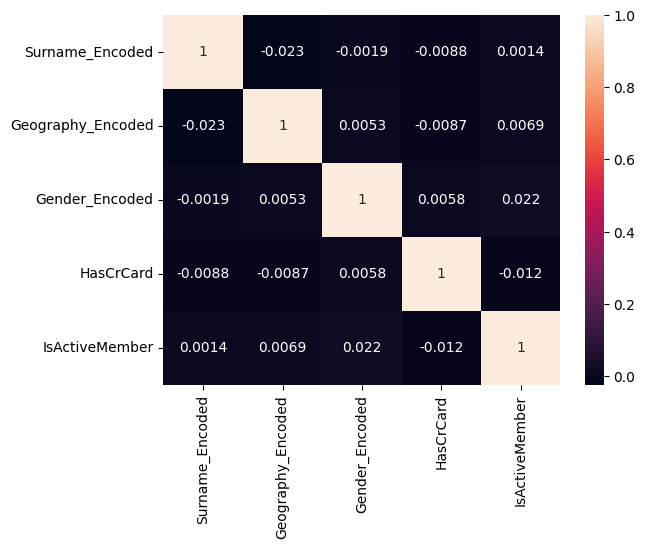

In [21]:
# vizualizing heatmap for relationship between encoded categorical features
sns.heatmap(df[categorical_features].corr(),annot=True)

<Axes: >

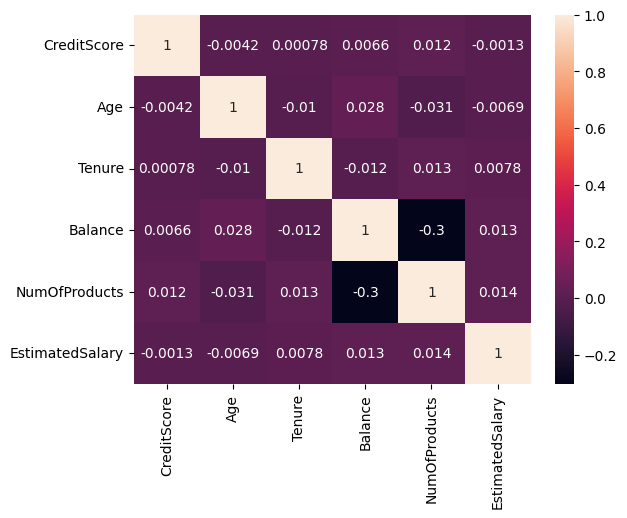

In [9]:
# # vizualizing heatmap for relationship between transformed categorical features
sns.heatmap(df[continuous_features].corr(),annot=True)

In [12]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

# seperating categorical and continuos features for training with seperate models
X_train_continuous = X_train[continuous_features]
X_train_categorical = X_train[categorical_features]
X_test_continuous = X_test[continuous_features]
X_test_categorical = X_test[categorical_features]

In [14]:
# training the Gaussian Naive Bayes model with continuous data
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train_continuous, y_train)

GaussianNB()

In [13]:
# training the Categorical Naive Bayes model with categorical data
categorical_nb = CategoricalNB()
categorical_nb.fit(X_train_categorical, y_train)

CategoricalNB()

In [16]:
# extracting probabilities from both models
gaussian_prob = gaussian_nb.predict_proba(X_test_continuous)[:, 1]
categorical_prob = categorical_nb.predict_proba(X_test_categorical)[:, 1]

# calcualting average probability of model predictions
combined_prob = (gaussian_prob + categorical_prob) / 2

In [17]:
# final prediction, threshold is set to 0.5
# if probability is > 0.5 then class 1 else class 0
y_pred_gaussian = gaussian_nb.predict(X_test_continuous)
y_pred_categorical = categorical_nb.predict(X_test_categorical)
y_pred_combined = np.where(combined_prob >= 0.5, 1, 0)

Accuracy for GaussianNB: 0.802
Confusion Matrix for GaussianNB:
[[1531   41]
 [ 355   73]]
Classification Report for GaussianNB:
              precision    recall  f1-score   support

           0       0.81      0.97      0.89      1572
           1       0.64      0.17      0.27       428

    accuracy                           0.80      2000
   macro avg       0.73      0.57      0.58      2000
weighted avg       0.78      0.80      0.75      2000

ROC AUC for GaussianNB: 0.7765956814344486


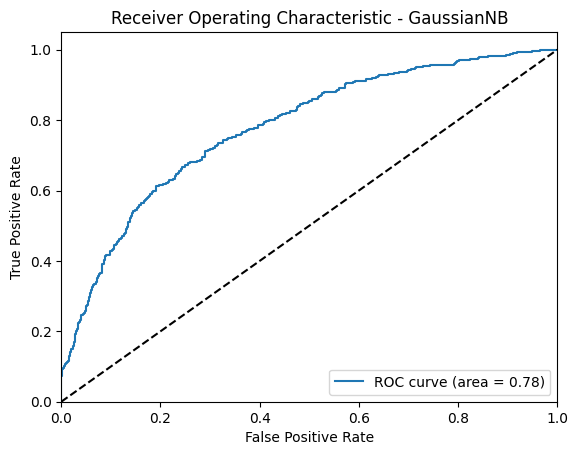

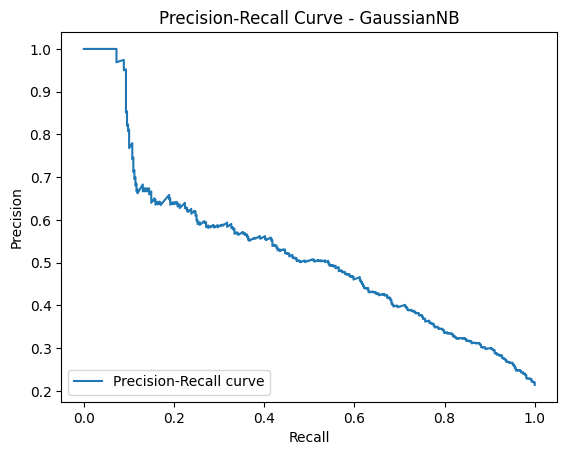

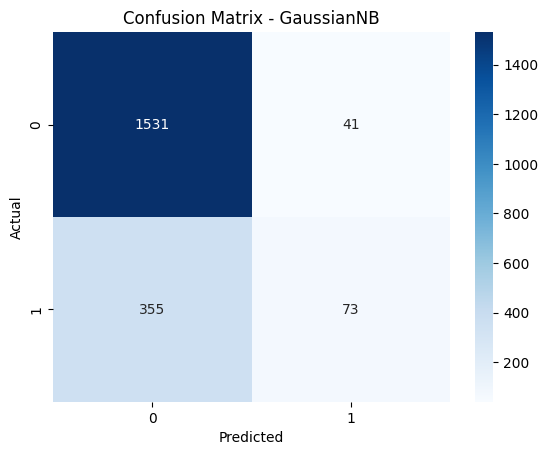

Accuracy for CategoricalNB: 0.7715
Confusion Matrix for CategoricalNB:
[[1506   66]
 [ 391   37]]
Classification Report for CategoricalNB:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1572
           1       0.36      0.09      0.14       428

    accuracy                           0.77      2000
   macro avg       0.58      0.52      0.50      2000
weighted avg       0.70      0.77      0.71      2000

ROC AUC for CategoricalNB: 0.6169844355663361


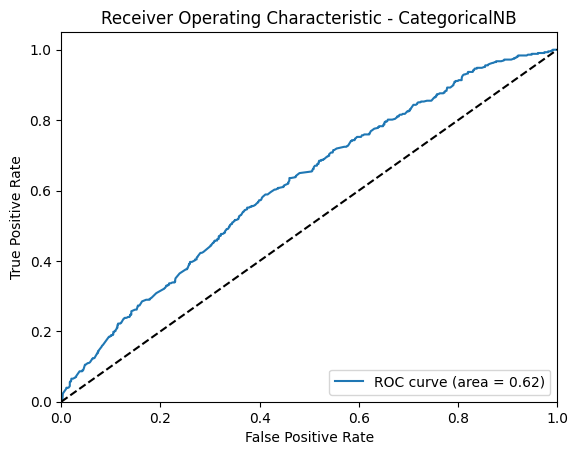

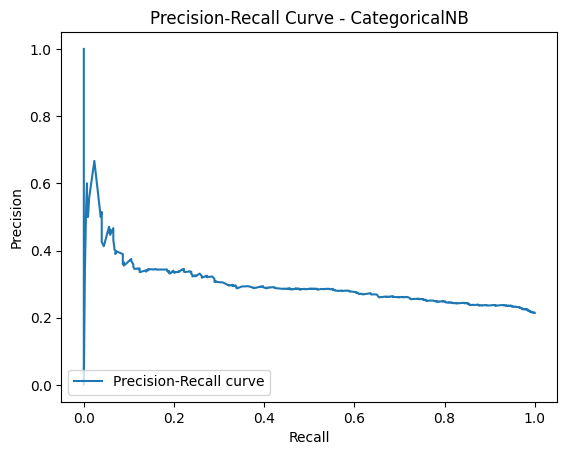

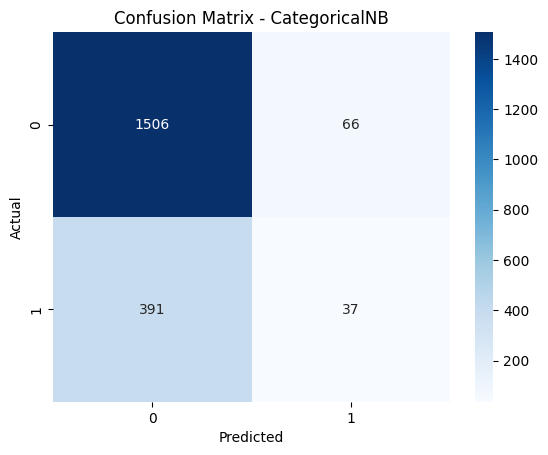

Accuracy for Hybrid Model: 0.8045
Confusion Matrix for Hybrid Model:
[[1570    2]
 [ 389   39]]
Classification Report for Hybrid Model:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1572
           1       0.95      0.09      0.17       428

    accuracy                           0.80      2000
   macro avg       0.88      0.54      0.53      2000
weighted avg       0.83      0.80      0.73      2000

ROC AUC for Hybrid Model: 0.7535210220922214


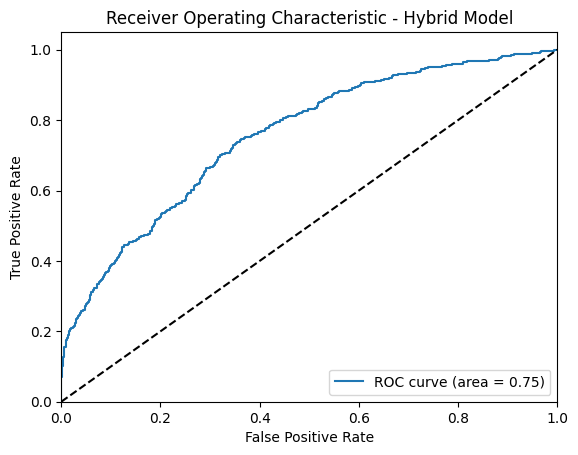

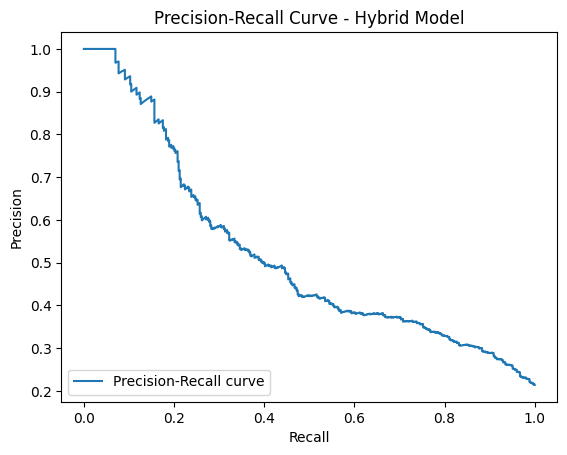

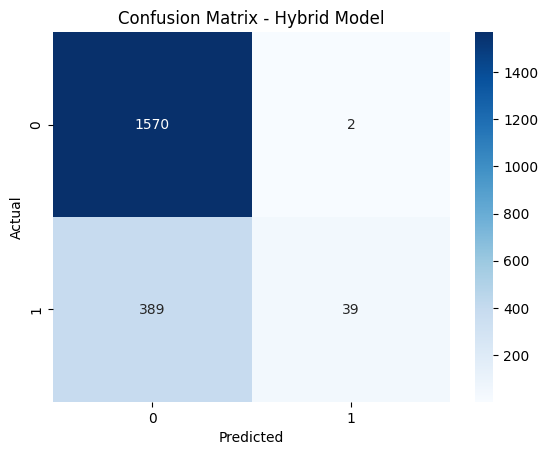

In [18]:
# calculating results
def evaluate_model(y_test, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    
    print(f'Accuracy for {model_name}: {accuracy}')
    print(f'Confusion Matrix for {model_name}:\n{conf_matrix}')
    print(f'Classification Report for {model_name}:\n{report}')
    print(f'ROC AUC for {model_name}: {roc_auc}')
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    plt.show()

    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate GaussianNB
evaluate_model(y_test, y_pred_gaussian, gaussian_prob, "GaussianNB")

# Evaluate CategoricalNB
evaluate_model(y_test, y_pred_categorical, categorical_prob, "CategoricalNB")

# Evaluate Hybrid Model
evaluate_model(y_test, y_pred_combined, combined_prob, "Hybrid Model")
